In [36]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
from fastai.vision import *

In [38]:
path = untar_data(URLs.BIWI_HEAD_POSE) 

In [39]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal 

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [40]:
fname = '09/frame_00667_rgb.jpg'

In [41]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt' 

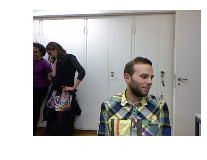

In [42]:
img = open_image(path/fname)
img.show()

In [43]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [44]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [45]:
get_ctr(fname)

tensor([263.9104, 428.5814])

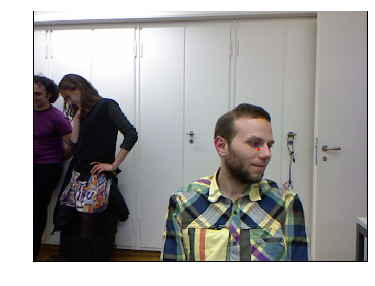

In [46]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

In [47]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

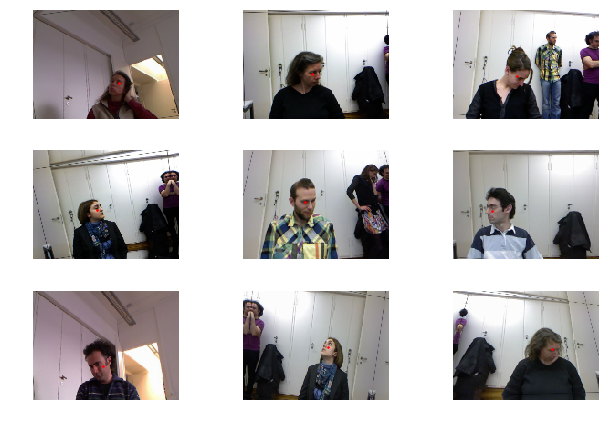

In [48]:
data.show_batch(3, figsize=(9,6))

In [49]:
learn = cnn_learner(data, models.resnet34)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


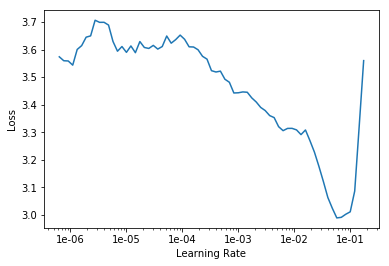

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
lr = 2e-2

In [52]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.115645,0.009901,01:53
1,0.039221,0.002751,01:53
2,0.014544,0.003506,01:51
3,0.008213,0.001078,01:52
4,0.006497,0.001929,01:52


In [53]:
learn.save('stage-1')

In [54]:
learn.load('stage-1');

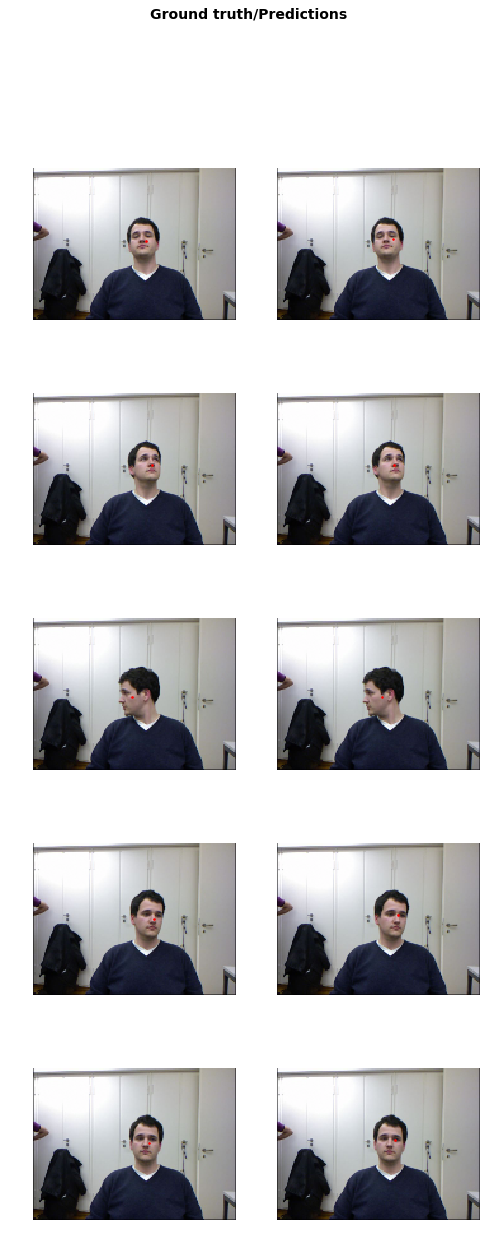

In [55]:
learn.show_results()

In [56]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

You can deactivate this warning by passing `no_check=True`.


/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 1

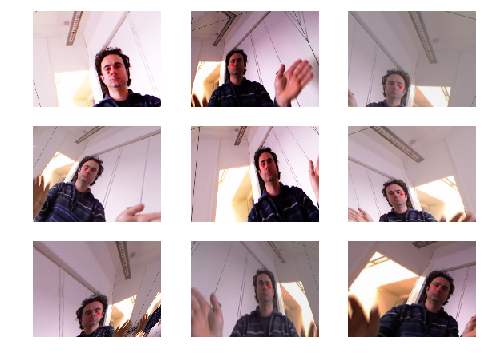

In [57]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

In [58]:
learn.export()

In [60]:
learn = load_learner(path)

In [61]:
img = data.valid_ds[0][0]
learn.predict(img)

(ImagePoints (120, 160),
 tensor([[-0.0685,  0.1367]]),
 tensor([-0.0685,  0.1367]))

In [64]:
img = open_image('man.jpeg')

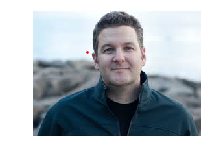

In [67]:
img.show(y=learn.predict(img)[0])